In [1]:
import numpy as np                                 
import pandas as pd                                 
import nltk                                        
import sklearn
import matplotlib.pyplot as plt

from nltk.corpus import stopwords                  

from sklearn.feature_extraction.text import TfidfVectorizer        

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")#Ignoring unnecessory warnings

In [2]:
all_data = pd.read_csv("data/Reviews.csv")
all_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


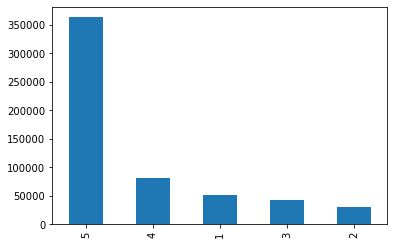

In [3]:
text_score_df = all_data[['Text','Score']].dropna()
ax=text_score_df.Score.value_counts().plot(kind='bar')
fig = ax.get_figure()

1    443777
0     82037
Name: Score, dtype: int64


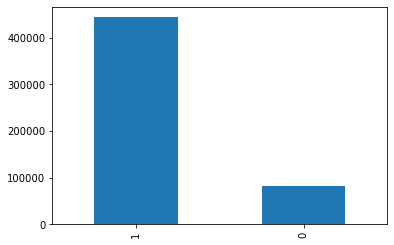

In [4]:
text_score_df = text_score_df[text_score_df['Score'] != 3]
text_score_df.Score[text_score_df.Score < 3] = 0
text_score_df.Score[text_score_df.Score > 3] = 1
print(text_score_df.Score.value_counts())

ax=text_score_df.Score.value_counts().plot(kind='bar')
fig = ax.get_figure()

1    443777
0     82037
Name: Score, dtype: int64


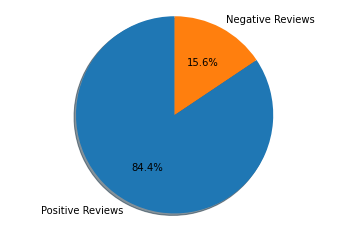

<Figure size 432x288 with 0 Axes>

In [5]:
size = text_score_df.Score.value_counts()
print(size)

labels = 'Positive Reviews', 'Negative Reviews'
sizes = [size[1],size[0]]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
plt.savefig('posNeg_dist.png')

## Basic datapreparation and cleaning

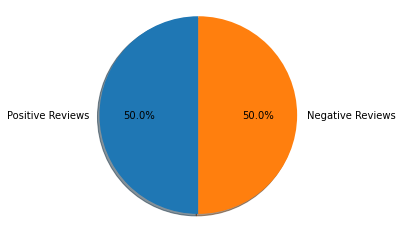

In [6]:
df_pos = text_score_df[text_score_df.Score==1][:10000]
df_neg = text_score_df[text_score_df.Score==0][:10000]
df = df_pos.append(df_neg) #Combine positive and negative
df = df.sample(frac=1).reset_index(drop=True) #Shuffle it and reset the index


labels = 'Positive Reviews', 'Negative Reviews'
sizes = [df_pos.Score.value_counts()[1], df_neg.Score.value_counts()[0]] 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [7]:
df_X = df['Text']
df_y = df['Score']

In [8]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Text cleaning

In [9]:
import re #Regular expressions operations

temp =[]
snow = nltk.stem.SnowballStemmer('english')

for sentence in df_X:
    sentence = sentence.lower()                 # Converting to lowercase
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)        #Removing HTML tags
    sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)        #Removing Punctuations
    
    words = [snow.stem(word) for word in sentence.split() if word not in stopwords.words('english')]   
    temp.append(words)
    
df_X = temp 


In [10]:
print(df_X[1])

['best', 'altern', 'cow', 'milk', 'first', '2', 'year', 'daughter', 'love', 'easier', 'digest', 'known', 'lesson', 'occur', 'certain', 'allergi', 'children', 'given', 'place', 'whole', 'milk', 'recommend', 'til', 'age', '2', 'second', 'child', 'use', 'love']


In [11]:
#Convert to normal sentence
sent = []
for row in df_X:
    sequ = ''
    for word in row:
        sequ = sequ + ' ' + word
    sent.append(sequ)

df_X = sent
print(df_X[1])

 best altern cow milk first 2 year daughter love easier digest known lesson occur certain allergi children given place whole milk recommend til age 2 second child use love


## Encoding the text with TF-IDF & applying Logistic Regression

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
pipe = Pipeline([('tfidf',tfidf),
                ('clf', LogisticRegression ()) 
                 ])

X_train, X_test, y_train, y_test = train_test_split(df_X,df_y, test_size = 0.20, random_state = 0, shuffle=True)

In [13]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('clf', LogisticRegression())])

In [14]:
y_pred = pipe.predict(X_test)
sklearn.metrics.accuracy_score(y_test, y_pred)

0.889

## Receives an accuracy of ~89%. Lets look at the top 20 neg/pos words


In [15]:
classifier = pipe.named_steps['clf']
vec = pipe.named_steps['tfidf']
w = vec.get_feature_names()

coef = classifier.coef_.tolist()[0]
coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
coeff_df_pos = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
coeff_df_neg = coeff_df_pos.tail(20)
print('')
print('-Top 20 positive-')
print(coeff_df_pos.head(20).to_string(index=False))
print('')
print('-Top 20 negative-')
print(coeff_df_neg.head(20).to_string(index=False))


-Top 20 positive-
           Word  Coefficient
          great     7.592457
         delici     6.105148
           love     5.996328
           best     5.783583
        perfect     5.240814
           good     4.732313
           nice     4.567296
          excel     4.503630
        favorit     4.070901
         wonder     3.960210
 high recommend     3.829880
         smooth     3.779337
           amaz     3.759252
           easi     3.488985
           glad     3.289660
          thank     3.105164
         awesom     3.085497
          alway     3.038736
          yummi     2.942137
           keep     2.861852

-Top 20 negative-
       Word  Coefficient
     ginger    -2.586037
       even    -2.635262
      throw    -2.692743
       wast    -2.817259
        toy    -2.967759
       away    -2.983513
      didnt    -3.035280
       weak    -3.206910
       tast    -3.212011
    thought    -3.221381
      bland    -3.403806
      money    -3.459935
    terribl    -3.703417
   

## Lets look at some reviews it classifies wrong

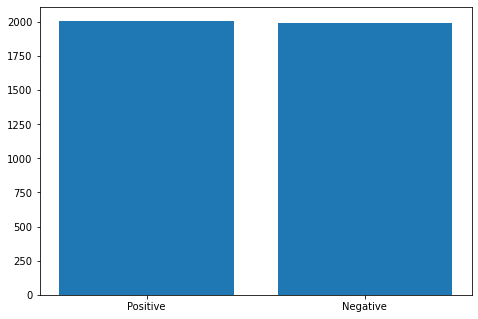

In [16]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
values = (sum(y_pred), len(y_pred)-sum(y_pred))
label = ('Positive', 'Negative')
ax.bar(label,values)
fig = ax.get_figure()

## Lets look at the confusion matrix

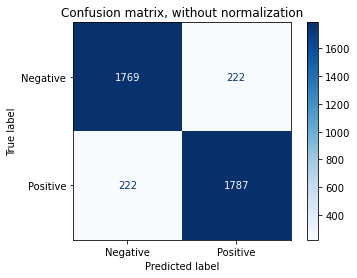

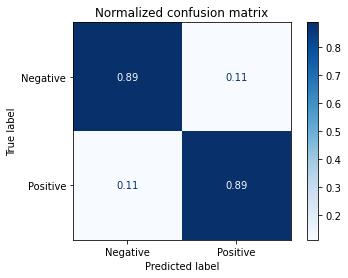

In [17]:


disp = plot_confusion_matrix(pipe, X_test, y_test,
                            display_labels=['Negative','Positive'],
                            cmap=plt.cm.Blues)  
disp.ax_.set_title("Confusion matrix, without normalization")
plt.show() 

disp = plot_confusion_matrix(pipe, X_test, y_test,
                            display_labels=['Negative','Positive'],
                            cmap=plt.cm.Blues,
                            normalize='true')  
disp.ax_.set_title("Normalized confusion matrix")
plt.show()  

In [18]:
print(classification_report(y_test, y_pred, target_names = ["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.89      0.89      0.89      1991
    Positive       0.89      0.89      0.89      2009

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



In [20]:
print('delicious => ',snow.stem('delicious'))
print('deliciously =>', snow.stem('deliciously'))

delicious =>  delici
deliciously => delici


In [21]:
print('smell => ',snow.stem('smell'))
print('smelled => ', snow.stem('smelled'))

smell =>  smell
smelled =>  smell
